In [1]:
# Implement libraries 
from pretty_midi import pretty_midi

import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import mir_eval.display
import librosa.display

import music21
from music21 import converter, instrument, note, chord, stream, corpus, midi, pitch
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import pydot

from sklearn.model_selection import train_test_split


In [2]:
# Create a function to convert midi files to a dataset
# Get all notes and chords from path ./midi_songs
def get_notes_and_chords(song_ind):
    note_dataset = []
    org_dataset = []
    ind = 0
    
    for midi_file in glob.glob("midi_songs/*.mid"):
        #print("Parsing ", midi_file)
        midi = converter.parse(midi_file)
        
        note_to_parse = None # Initialize variable
        
        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if (ind == song_ind):
                song_name = midi_file
                if isinstance(element, note.Note):
                    note_dataset.append(str(element.pitch))
                    org_dataset.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    note_dataset.append('.'.join(str(n) for n in element.normalOrder))
                    org_dataset.append('.'.join(str(n) for n in element.normalOrder))
            else:
                if isinstance(element, note.Note):
                    note_dataset.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    note_dataset.append('.'.join(str(n) for n in element.normalOrder))

        ind +=1

    with open('notes/notes', 'wb') as filepath:
        pickle.dump(note_dataset, filepath)
    
    print("Successfully parsing!")

    return note_dataset, org_dataset, song_name
    


In [3]:
# Mapping function - preprocessing
def preprocessing(notes):
    n_length = len(notes)
    # Sequence length is the stored length of sequence for predicting the next prediction
    sequence_length = 100 # CHOOSE

    # Generate a list with all the pitch names
    pitchnames = sorted(set(item for item in notes))
    #print(pitchnames)

    network_in = []
    network_out = []
    pattern = 0

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]

        # Normalize the pitch to be between 0-1
        in_pitch = [pitchnames.index(sequence_in[i])/len(pitchnames) for i in range(sequence_length)]
        out_pitch = pitchnames.index(sequence_out)

        network_in.append(in_pitch)
        network_out.append(out_pitch)
        pattern+=1


    # Reshape the input into a format compatible with LSTM layers
    # Shape - [ len(network_in), 100,1]
    reshaped_in = np.reshape(network_in, (pattern, sequence_length, 1))


    # One hot encoding for the output
    network_out = np_utils.to_categorical(network_out)

    return network_in, network_out, reshaped_in



In [4]:
# Create a neural network with LSTM
def LSTM_network(network_in, voc_n):
    model = Sequential()
    model.add(LSTM(512, recurrent_dropout=0.3, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(voc_n))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return model

In [5]:
def training(model, x_train, y_train):
    filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"
    lossModel = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    callbacks_list = [lossModel]

    history = model.fit(x_train, y_train, epochs=200, batch_size=100, callbacks=callbacks_list)

    model.save("my_model")
    
    print("Training finished!")
    
    return history


In [6]:
# ------- Training finished, now start to predict --------

In [7]:
# Generate notes from neural network
def generate_new_notes(model, pitchnames, voc_n, org_song, numb_new):
    
    # Starting point of the prediction
    pattern = [org_song[-1][i] for i in range(len(org_song[0]))]

    
    pred_out = []
    result = []
    
    # Generate (numb_new) # of notes
    for note_ind in range(numb_new):
        # reshape and normalize the input prediction
        pred_in = np.reshape(pattern, (1, len(pattern), 1))
        pred_in = pred_in/float(voc_n)
        
        pred = model.predict(pred_in, verbose = 0)
        
        ind = np.argmax(pred)
        n = pitchnames[ind]
        pred_out.append(n)
        
        pattern.append(ind)
        pattern = pattern[1:len(pattern)]

        
    return pred_out
    

In [8]:
def merge_to_song(pred_out, org_notes, numb_new):
    # Replace with predicted notes at the end
    new = org_notes[0:-1-numb_new] + pred_out
    return new


In [9]:
# Convert output to notes
def convert_pred_to_notes(pred_out):
    notes_out = []
    offset = 0
    
    # Generate chord/notes based on the value generated
    for i in pred_out:
        # If i is a chord
        if ('.' in i) or i.isdigit():
            note_in_c = i.split('.')
            notes = []
            # Create new notes from chord
            for curr_note in note_in_c:
                new_note = note.Note(int(curr_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            notes_out.append(new_chord)
        # Else: i is a note
        else:
            new_note = note.Note(i)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            notes_out.append(new_note)
            
        offset += 0.5
    
    
    return notes_out

In [10]:
# Create midi_file
def create_midi_file(pred, new_name):
    midi_stream = stream.Stream(pred)
    midi_stream.write('midi', fp = new_name)
    print("Midi-file successfully created!")

In [11]:
change_ind = 80
new_name = 'My_song.mid'
numb_notes = 200

notes, org_notes, song_name = get_notes_and_chords(change_ind)
voc_n = len(set(notes))
pitchnames = sorted(set(item for item in notes))

network_in, network_out, reshaped_norm_in = preprocessing(notes)
original_in, _,_  = preprocessing(org_notes)

# Split the network into training set (85 %) and validation(test) set (15 %)
in_train, in_test, out_train, out_test= train_test_split(reshaped_norm_in, network_out, test_size =0.15)

# If want to traing the network and calculate the loss for the training, uncomment this part
"""# Define the model
model = LSTM_network(in_train, voc_n)

# Start training
#history = training(model, in_train, out_train)"""

# Load trained model and weights
model = keras.models.load_model('my_model')
model.load_weights('weights-improvement-200-0.6249-bigger.h5')

# Generate new sequence by prediction with the trained model and weights
pred_sequence = generate_new_notes(model, pitchnames, voc_n, original_in, numb_notes)

# Implement the new sequence into the original song
pred_song = merge_to_song(pred_sequence, org_notes, numb_notes)

# Create a midi-file for the sequence 
pred_notes = convert_pred_to_notes(pred_sequence)
create_midi_file(pred_notes,'Sequence.mid')

# Create a midi-file for the new song
new_notes = convert_pred_to_notes(pred_song)
create_midi_file(new_notes, new_name)


Successfully parsing!
Midi-file successfully created!
Midi-file successfully created!


In [ ]:
# ------- Evaluate the prediction and the model --------

In [18]:
def plot_piano_roll(pm, filename, start_pitch, end_pitch, numb_notes, org_notes, fs=100):
    fig, ax = plt.subplots()
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',ax = ax)
    ax.set(title=filename)


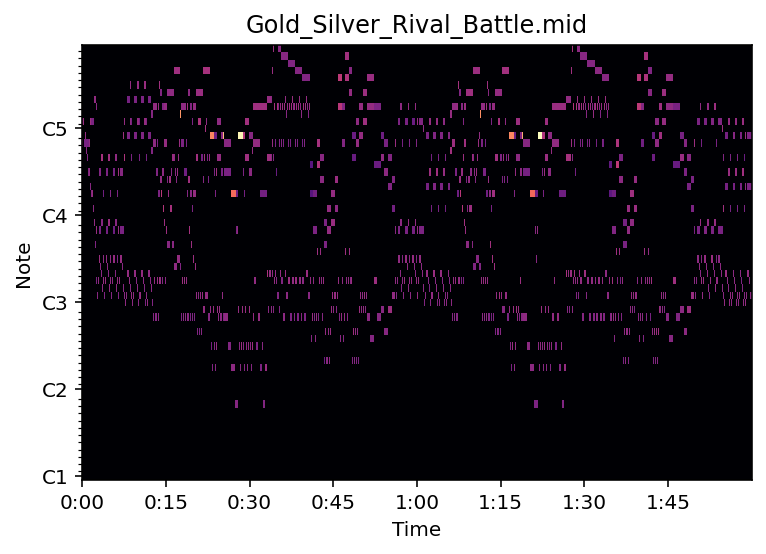

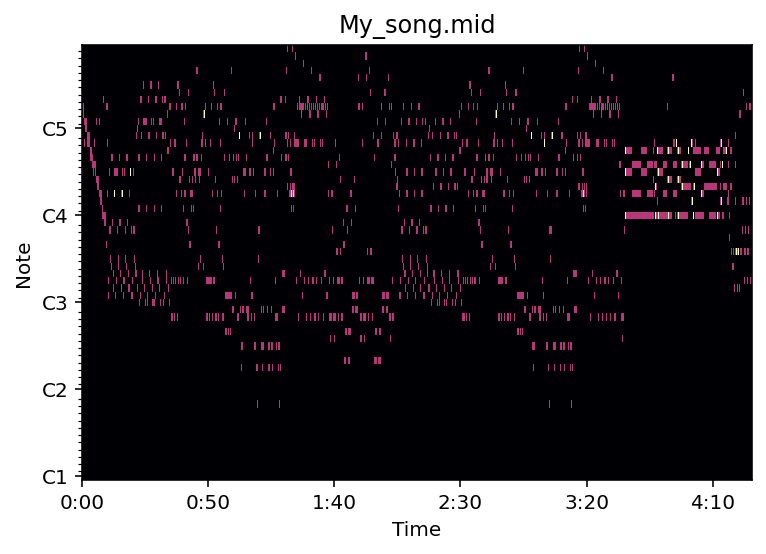

In [21]:
# Plot the rolls for the original song and with the generated part
midi_pretty_format = pretty_midi.PrettyMIDI(song_name)
filename = song_name.split('/')[-1]
plot_piano_roll(midi_pretty_format,filename, 24, 84,numb_notes, org_notes)

midi_pretty_format = pretty_midi.PrettyMIDI(new_name)
plot_piano_roll(midi_pretty_format,new_name, 24, 84, numb_notes, org_notes)
print(midi_pretty_format)

In [16]:
# Evaluate the accuracy of the model for the test set
loss_test = model.evaluate(in_test, out_test, batch_size=50)
print("The loss for the test set is: ", loss_test)

17/17 [==============================] - 9s 522ms/step - loss: 0.4830
The loss for the test set is:  0.48304513096809387


In [17]:
# Plot the loss through the training
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
print(history.history.keys())

NameError: name 'history' is not defined

In [ ]:
# Display network in a png file
model = keras.models.load_model('my_model')
keras.utils.plot_model(model, to_file='my_network.png', show_shapes=False)